# Micromodelling
_SoTA Hackathon 2025_

_Sergio Garcia Busto - PhD Student @ University of Cambridge (Wellcome Sanger Institute)_

## Modelling the dynamics of microbial communities

Modelling biological systems is challenging: data is noisy, the system is often highly stochastic and their underlying terms are challenging to approximate. In systems/mathematical biology, it is common to use Ordinary Differential Equations (ODEs), Partial Differential Equations (PDEs) or Stochastic Differential Equations (SDEs) for a variety of data types and modelling tasks. 

Importantly, the complexity of biological systems causes many model fitting problems to require Bayesian Inference in the form of simulation-based inference (SBI), given that model likelihoods are often intractable. In this way, the parameters of our model can be inferred.


### The problem

However, there is an important recurrent issue in biological modelling tasks: model misspecification. The scientist, or user, might not have full knowledge of the underlying system to specify a model that is accurate or robust enough to model the dynamics of the system reliably. In addition, there could be noise terms that are not captured by our mathematical model. 

In this hackathon, I have explored different ways to use neural networks to make these models more interpretable by fitting unknown terms of the underlying system.

## A case study: microbial interactions

Let's look at a synthetic example of a community of 3 microbial species which compete for resources. One becomes dominant, and the other two, although they have different growth rates, decay to their steady-state. These two growth rates will be our parameters to be inferred. The full model could be used to estimate up to 12 fully interpretable parameters, and is defined as follows:

$$
\frac{dx_1}{dt} = r_1 x_1 \left( 1 - \frac{x_1 + \alpha_{12} x_2 + \alpha_{13} x_3}{K_1} \right)
$$

$$
\frac{dx_2}{dt} = r_2 x_2 \left( 1 - \frac{x_2 + \alpha_{21} x_1 + \alpha_{23} x_3}{K_2} \right)
$$

$$
\frac{dx_3}{dt} = r_3 x_3 \left( 1 - \frac{x_3 + \alpha_{31} x_1 + \alpha_{32} x_2}{K_3} \right)
$$

Where:
- $x_1, x_2, x_3$ are the populations of species 1, 2, and 3, respectively.
- $r_1, r_2, r_3$ are the intrinsic growth rates of species 1, 2, and 3.
- $K_1, K_2, K_3$ are the carrying capacities of species 1, 2, and 3.
- $\alpha_{12}, \alpha_{13}, \alpha_{21}, \alpha_{23}, \alpha_{31}, \alpha_{32}$ are the competition coefficients that model the interactions between the species.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def microbial_2p_model(u, t, params):
    # Parameters (intrinsic growth rates: competition coefficients and carrying capacities were replaced by constants)
    r1, r2 = params
    # Populations (x1, x2, x3 correspond to species 1, 2, 3)
    x1, x2, x3 = u

    # Differential equations (dx/dt)
    dx1dt = r1 * x1 * (1 - (x1 + 0.2 * x2 + 0.2 * x3) / 5)
    dx2dt = r2 * x2 * (1 - (x2 + 0.2 * x1 + 0.2 * x3) / 5)
    dx3dt = x3 * (1 - (x3 + 0.2 * x1 + 0.2 * x2) / 10)

    return [dx1dt, dx2dt, dx3dt]


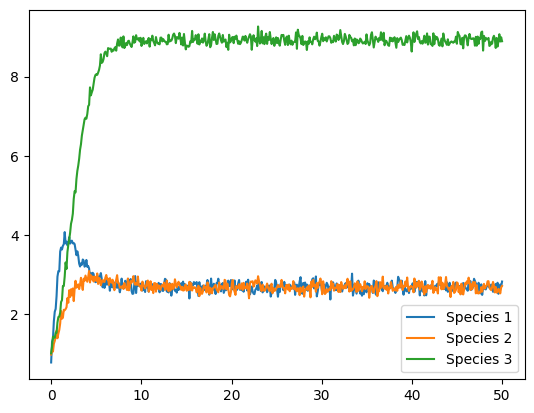

In [2]:
from scipy.integrate import odeint

# These would be the parameters of the entire model (12) for reference
# params = [3.0, 1.0, 1.0, 5.0, 5.0, 10.0, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2]

# Our parameters to infer
params = [3.0, 1.0]

# Initial populations
u0 = [1.0, 1.0, 1.0]

# Time span for simulation
tspan = np.linspace(0, 50, 500)

# Simulate the true data (without noise)
def simulate_system(tspan, params, u0):
    def model_odes(u, t, params):
        return microbial_2p_model(u, t, params)
    
    solution = odeint(model_odes, u0, tspan, args=(params,))
    return solution

true_data = simulate_system(tspan, params, u0)

# Add some noise to the true data
noise_std = 0.1
noisy_data = true_data + noise_std * np.random.randn(*true_data.shape)

plt.plot(tspan, noisy_data[:, 0], label="Species 1")
plt.plot(tspan, noisy_data[:, 1], label="Species 2")
plt.plot(tspan, noisy_data[:, 2], label="Species 3")
plt.legend()
plt.show()


What we will do now is to simply infer the parameters of our model ($r_1$ and $r_2$) using the simplest Approximate Bayesian Computation algorithm _(Note: although neural networks such as mixed density estimators and more complex algorithms can be used for SBI, ABC was selected for simplicity)_. This algorithm will sample from parameter space randomly and will accept parameters if the measured distance lies below a distance threshold. The distance function is used to measure the 'similarity' of trajectories, and in this case, Euclidean distance is used.

In [3]:
# Build a distance function, which can handle any number of species
def euclidean_distance_multiple_trajectories(observed_trajectories, simulated_trajectories):
    num_trajectories = len(observed_trajectories)
    total_distance = 0.0

    for i in range(num_trajectories):
        observed_data = observed_trajectories[i]
        simulated_data = simulated_trajectories[i]

        # Calculate the Euclidean distance between observed and simulated data
        euclidean_distance = np.linalg.norm(observed_data - simulated_data)

        # Accumulate the distances
        total_distance += euclidean_distance

    # Average the distances over all trajectories
    average_distance = total_distance / num_trajectories

    return average_distance

# Simulator for ABC
def simulate_model(params, y0, t):
    return odeint(microbial_2p_model, y0, t, args=(params,))

# REJ-ABC (Rejection ABC)
def abc_rejection(observed_data, y0, t, num_samples, threshold):
    # Store accepted parameters
    accepted_parameters = []

    for _ in range(num_samples):
        # Sample parameters from uniform prior distributions. We use wide priors to test the power of this approach.
        params = np.random.uniform(low=[2, 0], 
                                    high=[4, 2])
        
        # Simulate model with sampled parameters
        simulated_data = simulate_model(params, y0, t)
        
        # Calculate the distance
        dist = euclidean_distance_multiple_trajectories(observed_data, simulated_data)  # Use final state for comparison
        
        # Acceptance criteria, threshold might need to be varied
        if dist < threshold:
            accepted_parameters.append(params)

    return np.array(accepted_parameters)

# Parameters for REJ-ABC which need to be varied to leverage speed and accuracy
num_samples = 5000  # Number of parameter samples
threshold = 0.167
# Run REJ-ABC
accepted_params_abc = abc_rejection(noisy_data, u0, tspan, num_samples, threshold)
print(f'\nWe have accepted {accepted_params_abc[:,0].shape[0]} parameter sets out of {num_samples} samples')



We have accepted 169 parameter sets out of 5000 samples


After we have accepted a set of parameter combinations, we have obtained our posterior distributions, which measure the credibility of our parameter values. According to the Central Limit Theorem, ABC posteriors converge to normally distributed posterior distributions centered at the true value, as the threshold $\epsilon \rightarrow 0$ and as the sample size $n \rightarrow \infty$. This is not guaranteed with neural network-based approaches. 

We can see whether they encompass the true value, showing that inference was successful with respect to our wide uniform prior distributions.

/Users/sb79/miniforge3/lib/python3.12/site-packages/seaborn/axisgrid.py:1832: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=self.x, y=self.y, **kwargs)


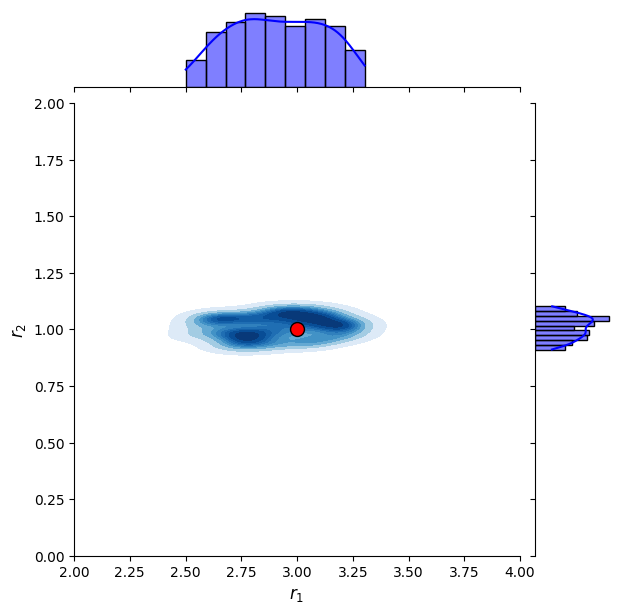

In [16]:
p1 = accepted_params_abc.T[0]
p2 = accepted_params_abc.T[1]
#print(np.median(p1), np.median(p2))

g = sns.JointGrid(x=p1, y=p2)

g.plot_joint(sns.kdeplot, shade=True, cmap="Blues") 
g.plot_marginals(sns.histplot, kde=True, color="blue")  # Marginal histograms with KDE
g.set_axis_labels(r'$r_1$', r'$r_2$', fontsize=12) 

g.ax_joint.set_xlim(2, 4) 
g.ax_joint.set_ylim(0, 2) 

# Optionally, adjust limits for the marginal histograms
g.ax_marg_x.set_xlim(2,4)
g.ax_marg_y.set_ylim(0,2)

# Add the true value point to the joint plot
g.ax_joint.scatter(3, 1, color='red', s=100, edgecolor='black', label='True Value')

# Display the plot
plt.show()

**Note: neural networks can be used at different steps of the inference procedure: for instance, the distance function, summary statistics of trajectories and posterior distributions can be learned. However, these applications were omitted to focus on the application of neural networks to address model misspecification.**

## How do we address model misspecification?

The best way to address model misspecification for this application using neural networks would be to implement a Universally Differentiable Equation (UDE), a neural Ordinary Differential Equation (NODE) or a Bayesian Polynomial Neural Ordinary Differential Equation. These applications effectively add a neural network as a term in the ODE to capture dynamics that are elusive to the current model. The common approach is to incorporate the ODE in the loss function, thereby optimising both the ODE loss and the overall leftover variation unexplained by the model. Although this was the objective of micromodelling, integrating it with Bayesian Inference is nontrivial (proved to be more challenging than expected). In fact, this only has been recently explored (https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1012414). 

The loss of a neural ODE would be composed of the residual loss $\mathcal{L}_{\text{data}}$ and the ODE loss, $\mathcal{L}_{\text{ODE}}$, weighed by factors $\phi$ and $\lambda$. The weights essentially dictate the preference of data compatibility with the ODE versus the learned NN.

$$\mathcal{L}_{\text{total}} = \lambda \mathcal{L}_{\text{data}} + \phi \mathcal{L}_{\text{ODE}}$$

The data loss simply measures the residuals:
$$\mathcal{L}_{\text{data}} = \sum_{i=1}^{N} \left\| x_{\text{pred}}(t_i) - x_{\text{true}}(t_i) \right\|^2$$

And the ODE loss measures the extent to which the NN respects the structure of the ODE model:
$$\mathcal{L}_{\text{ODE}} = \sum_{i=1}^{N} \left\| \frac{d x_{\text{pred}}(t_i)}{dt} - f(x_{\text{pred}}(t_i), \theta, t_i) \right\|^2
$$

In the above example, $\frac{d x_{\text{pred}}(t_i)}{dt}$ is the approximation of the derivative of the predicted trajectory, and $f(x_{\text{pred}}(t_i), \theta, t_i)$ is the function learned by the NN that defines the dynamics of the system.


#### Another option

As an alternative to this, I developed an approach that effectively learns the residuals of every iteration of the inference procedure. The neural network will approximate the leftover variation and will improve the posterior distributions, as they will resemble the normally-distributed posteriors that ABC converges to more closely. This is because the algorithm will prioritise simulations that have learnable misspecification. In the following implementation, this is tested using the example shown previously, which only contains noise - however, it should ideally be tested with proper model misspecifications.

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the neural network model to learn the residuals
class ResidualNN(nn.Module):
    def __init__(self):
        super(ResidualNN, self).__init__()
        self.fc1 = nn.Linear(4, 10)  # Input: x1, x2, x3, t (species + time)
        self.fc2 = nn.Linear(10, 10)
        self.fc3 = nn.Linear(10, 3)  # Output: residuals for dx1/dt, dx2/dt, dx3/dt

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

In [12]:
# Main ABC Loop with the NN
def abc_with_neural_network(n_simulations, u0, tspan, observed_data, threshold):
    accepted_params = []
    corrected_simulations = []
    
    for i in range(n_simulations):
        if i % 100 == 0:
            print(f"Carrying out simulation n {i}.\n")
        params = np.random.uniform(low=[2, 0], 
                                    high=[4, 2])
        
        # Simulate model with sampled parameters
        simulated_data = simulate_model(params, u0, tspan)

        # Fit the neural network to the residuals of every simulation performed
        tspan_tensor = torch.tensor(tspan, dtype=torch.float32).unsqueeze(1)  # Time points
        noisy_data_tensor = torch.tensor(observed_data, dtype=torch.float32)

        # Initialize the neural network
        residual_nn = ResidualNN()

        # Define optimizer and loss function
        optimizer = optim.Adam(residual_nn.parameters(), lr=0.001)
        loss_fn = nn.MSELoss()
        n_epochs = 500

        for epoch in range(n_epochs):
            optimizer.zero_grad()
            input_data = torch.cat([noisy_data_tensor[:, 0:3], tspan_tensor], dim=1)
            
            # Predict the residuals using the neural network
            predicted_residuals = residual_nn(input_data)
            
            # Compute the corrected model output (base model + residuals)
            corrected_output = noisy_data_tensor + predicted_residuals

            # Compute the loss (MSE between corrected output and true data)
            loss = loss_fn(corrected_output, noisy_data_tensor)
            
            # Backpropagation and optimization
            loss.backward()
            optimizer.step()
            
            if i % 100 == 0:
                if epoch % 100 == 0:
                    print(f"Epoch {epoch}/{n_epochs}, Loss: {loss.item()}")
        
        corrected_output_tensor = corrected_output.detach().numpy()

        # Calculate the Euclidean distance
        dist = euclidean_distance_multiple_trajectories(corrected_output_tensor, simulated_data)
        
        # Acceptance criteria depending on the threshold
        if dist < threshold:    
            # Store the parameters and the corrected output
            accepted_params.append(params)
            corrected_simulations.append(corrected_output)

    return accepted_params, corrected_simulations


In [13]:
# Define initial conditions and time span for the simulation
u0 = [1.0, 1.0, 1.0]
tspan = np.linspace(0, 50, 500)

# Run the ABC with Neural Network integration
n_simulations = 5000  # Number of ABC simulations
threshold = 0.167
accepted_params, corrected_simulations = abc_with_neural_network(n_simulations, u0, tspan, noisy_data, threshold)

accepted_params_list = np.array([arr.tolist() for arr in accepted_params])
print(f'\nWe have accepted {accepted_params_list[:,0].shape[0]} parameter sets out of {n_simulations} samples')

Carrying out simulation n 0.

Epoch 0/500, Loss: 3.4190547466278076
Epoch 100/500, Loss: 0.010234395042061806
Epoch 200/500, Loss: 0.0011826785048469901
Epoch 300/500, Loss: 0.00038925925036892295
Epoch 400/500, Loss: 0.0002063090360024944
Carrying out simulation n 100.

Epoch 0/500, Loss: 0.3405948877334595
Epoch 100/500, Loss: 0.001313965767621994
Epoch 200/500, Loss: 0.00022903502394910902
Epoch 300/500, Loss: 6.890245276736096e-05
Epoch 400/500, Loss: 4.931465446134098e-05
Carrying out simulation n 200.

Epoch 0/500, Loss: 2.518455982208252
Epoch 100/500, Loss: 0.0028976425528526306
Epoch 200/500, Loss: 0.001826434745453298
Epoch 300/500, Loss: 0.0014674459816887975
Epoch 400/500, Loss: 0.0008931031916290522
Carrying out simulation n 300.

Epoch 0/500, Loss: 0.6845737099647522
Epoch 100/500, Loss: 0.003380637150257826
Epoch 200/500, Loss: 0.0017683253390714526
Epoch 300/500, Loss: 0.0008937846287153661
Epoch 400/500, Loss: 0.0003378613037057221
Carrying out simulation n 400.

Epoch

/Users/sb79/miniforge3/lib/python3.12/site-packages/seaborn/axisgrid.py:1832: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=self.x, y=self.y, **kwargs)


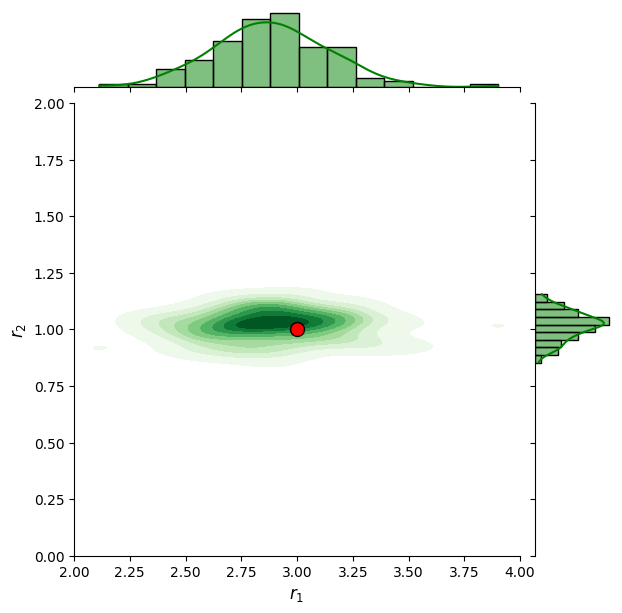

In [ ]:
p1 = accepted_params_list.T[0]
p2 = accepted_params_list.T[1]
#print(np.median(p1), np.median(p2))

g = sns.JointGrid(x=p1, y=p2)

g.plot_joint(sns.kdeplot, shade=True, cmap="Greens") 
g.plot_marginals(sns.histplot, kde=True, color="green")  # Marginal histograms with KDE
g.set_axis_labels(r'$r_1$', r'$r_2$', fontsize=12) 

g.ax_joint.set_xlim(2, 4) 
g.ax_joint.set_ylim(0, 2) 

g.ax_marg_x.set_xlim(2,4)
g.ax_marg_y.set_ylim(0,2)

# Add the true value point to the joint plot
g.ax_joint.scatter(3, 1, color='red', s=100, edgecolor='black', label='True Value')

# Display the plot
plt.show()

We can see that with the same number of simulations, posteriors appear more normally distributed, which can indicate improved reliability in downstream analyses and the ability to capture model misspecifications.

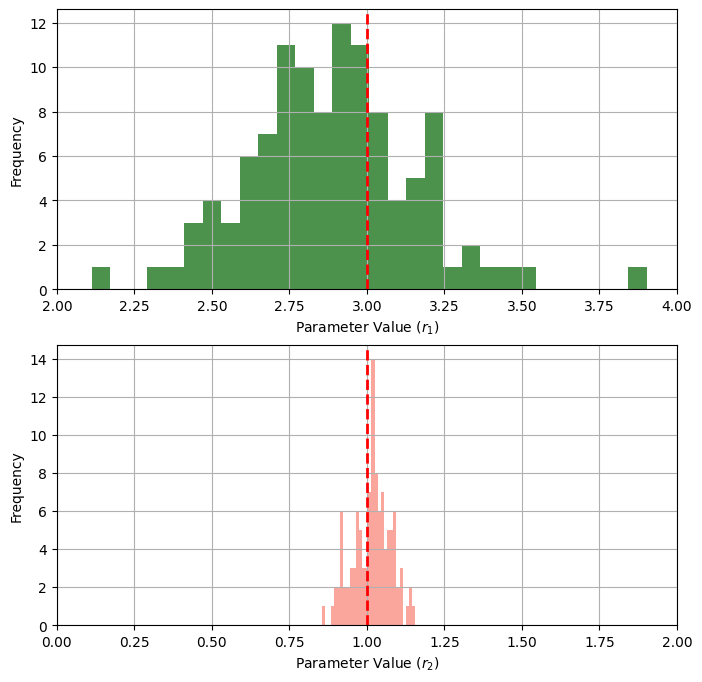

In [15]:
# Another way to visualise the normality of posterior distributions

if accepted_params_list.size > 0:
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.hist(accepted_params_list[:, 0], bins=30, alpha=0.7, color='darkgreen')
    plt.axvline(x=params[0], color='red', linestyle='--', linewidth=2)
    plt.xlabel(r'Parameter Value ($r_1$)')
    plt.ylabel('Frequency')
    plt.xlim(2, 4)
    plt.grid()
    
    plt.subplot(2, 1, 2)
    plt.hist(accepted_params_list[:, 1], bins=30, alpha=0.7, color='salmon')
    plt.xlabel(r'Parameter Value ($r_2$)')
    plt.ylabel('Frequency')
    plt.axvline(x=params[1], color='red', linestyle='--', linewidth=2)
    plt.xlim(0, 2)
    
    plt.grid()
    plt.show()
else:
    print("No parameters were accepted.")


## Conclusions and future directions

In conclusion, I implemented a simple approach that can help model misspecification that can be integrated in a Bayesian Inference task. Due to time and compute constraints, I could not test this approach further (i.e., perform posterior predictive checks), nor get a sensible neural ODE to carry out Bayesian Inference on. However, it would be interesting to test/explore the following:
- How does the NN-enhanced inference perform if we misspecify the model? Does it learn hidden parameters better than random noise? How can we prevent overfitting such that the NN only learns model misspecification?
- After desigining a neural ODE, what is the optimal way to integrate parameter sampling in inference with NN training?
- **Implement this with biological data, which requires extensive curation, and could not be preprocessed in the duration of this hackathon. This should be directly applicable to abundance data of different microbial species, for instance in the human gut or in a bioreactor for industrial production.**